<a href="https://colab.research.google.com/github/ckgpeace/EVA4/blob/master/S4/EVA4_S4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:
# Model 6:
# Things Tried: 1. Maxpooling 2. Dropout 4. Batch Normalization
# Accuracy: 99.4% in 18th epoch
# Params = 11,178

class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()
      
      self.conv1 = nn.Conv2d(1, 8, 3)     #input-28 | Output-26 | RF-3
      self.bn1 = nn.BatchNorm2d(8)
      self.do1 = nn.Dropout(0.1)

      self.conv2 = nn.Conv2d(8, 8, 3)     #input-26 | Output-24 | RF-5
      self.bn2 = nn.BatchNorm2d(8)
      self.do2 = nn.Dropout(0.1)

      self.conv3 = nn.Conv2d(8, 8, 3)     #input-24 | Output-22 | RF-7
      self.bn3 = nn.BatchNorm2d(8)
      self.do3 = nn.Dropout(0.1)

      self.pool1 = nn.MaxPool2d(2, 2)     #input-22 | Output-11 | RF-14
      
      self.conv4 = nn.Conv2d(8, 16, 3)    #input-11 | Output-09 | RF-16
      self.bn4 = nn.BatchNorm2d(16)
      self.do4 = nn.Dropout(0.1)

      self.conv5 = nn.Conv2d(16, 16, 3)   #input-09 | Output-07 | RF-18
      self.bn5 = nn.BatchNorm2d(16)
      self.do5 = nn.Dropout(0.1)

      self.conv6 = nn.Conv2d(16, 16, 3)   #input-07 | Output-05 | RF-20
      self.bn6 = nn.BatchNorm2d(16)
      self.do6 = nn.Dropout(0.1)

      self.conv7 = nn.Conv2d(16, 10, 5)   #input-04 | Output-01 |


    def forward(self, x):
      x = F.relu(self.conv1(x))
      x = self.bn1(x)
      x = self.do1(x)

      x = F.relu(self.conv2(x))
      x = self.bn2(x)
      x = self.do2(x)

      x = F.relu(self.conv3(x))
      x = self.bn3(x)
      x = self.do3(x)

      x = self.pool1(x)

      x = F.relu(self.conv4(x))
      x = self.bn4(x)
      x = self.do4(x)

      x = F.relu(self.conv5(x))
      x = self.bn5(x)
      x = self.do5(x)

      x = F.relu(self.conv6(x)) # No Batch Normalization and drop out before final layer

      x = self.conv7(x) # No Relu function before softmax layer

      x = x.view(-1, 10)
      
      return F.log_softmax(x)

In [3]:
# !pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
       BatchNorm2d-2            [-1, 8, 26, 26]              16
           Dropout-3            [-1, 8, 26, 26]               0
            Conv2d-4            [-1, 8, 24, 24]             584
       BatchNorm2d-5            [-1, 8, 24, 24]              16
           Dropout-6            [-1, 8, 24, 24]               0
            Conv2d-7            [-1, 8, 22, 22]             584
       BatchNorm2d-8            [-1, 8, 22, 22]              16
           Dropout-9            [-1, 8, 22, 22]               0
        MaxPool2d-10            [-1, 8, 11, 11]               0
           Conv2d-11             [-1, 16, 9, 9]           1,168
      BatchNorm2d-12             [-1, 16, 9, 9]              32
          Dropout-13             [-1, 16, 9, 9]               0
           Conv2d-14             [-1, 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


In [0]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [6]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(20):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0691, Accuracy: 9777/10000 (98%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0490, Accuracy: 9832/10000 (98%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0379, Accuracy: 9875/10000 (99%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0343, Accuracy: 9874/10000 (99%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9918/10000 (99%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0280, Accuracy: 9916/10000 (99%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9922/10000 (99%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9926/10000 (99%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9923/10000 (99%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9925/10000 (99%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9929/10000 (99%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Accuracy: 9927/10000 (99%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Accuracy: 9925/10000 (99%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0292, Accuracy: 9918/10000 (99%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9924/10000 (99%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0278, Accuracy: 9919/10000 (99%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9921/10000 (99%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9941/10000 (99%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0273, Accuracy: 9921/10000 (99%)



loss=0.02401886321604252 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 42.72it/s]



Test set: Average loss: 0.0254, Accuracy: 9926/10000 (99%)



NameError: ignored

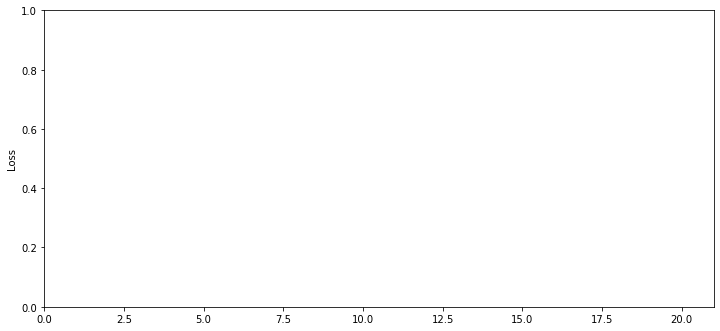

In [7]:
# plot training history
# Need to fix this
import matplotlib.pyplot as plt
import math
e = epoch
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
ax = plt.gca()
ax.set_xlim([0, e+2])
plt.ylabel('Loss')
plt.plot(range(1, e + 2), train_losses[:e+1], 'r', label='Training Loss')
plt.plot(range(1, e + 2), val_losses[:e+1], 'b', label='Validation Loss')
ax.grid(linestyle='-.')
plt.legend()
plt.subplot(2,1,2)
ax = plt.gca()
ax.set_xlim([0, e+2])
plt.ylabel('Accuracy')
plt.plot(range(1, 100), train_accu[:e+1], 'r', label='Training Accuracy')
plt.plot(range(1, e + 2), val_accu[:e+1], 'b', label='Validation Accuracy')
ax.grid(linestyle='-.')
plt.legend()
plt.show()